In [201]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Import the datasets and save it to a variable

train1 = pd.read_csv("../notebook/train.csv")
test1 = pd.read_csv("../notebook/test.csv")

# Check the first 5 rows of the data
train1.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Checks for missing values in the DataFrame train1
train1.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [ ]:
# Checks Dataframe info
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# Checks data type of each column in the DataFrame
train1.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [ ]:
# counts how many people survived and how many did not
survival_counts = train1['Survived'].value_counts()
survival_counts

Survived
0    549
1    342
Name: count, dtype: int64

In [ ]:
# Checks the unique values of columns (Sec, Embarked and Pclass) with their counts 
categorical_cols = ['Sex', 'Embarked', 'Pclass']
for col in categorical_cols:
    print(f"\n{col} unique values:")
    print(train1[col].value_counts())


Sex unique values:
Sex
male      577
female    314
Name: count, dtype: int64

Embarked unique values:
Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

Pclass unique values:
Pclass
3    491
1    216
2    184
Name: count, dtype: int64


In [261]:
# Create age groups:
train1['AgeGroup'] = pd.cut(train1['Age'], bins=[0, 12, 18, 35, 60, 80], 
                            labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

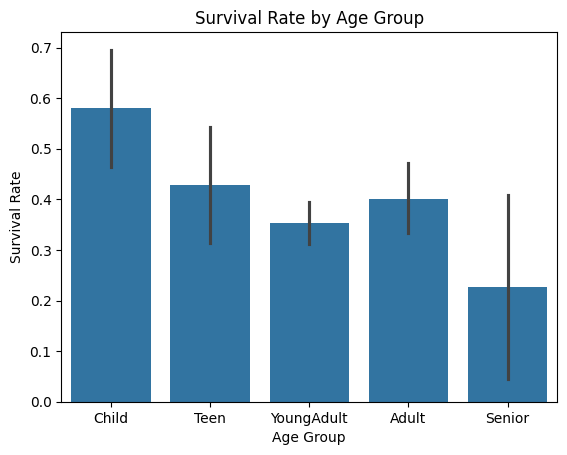

In [262]:
# Visualize survival rate per age group
sns.barplot(x='AgeGroup', y='Survived', data=train1)
plt.title("Survival Rate by Age Group")
plt.ylabel("Survival Rate")
plt.xlabel("Age Group")
plt.show()

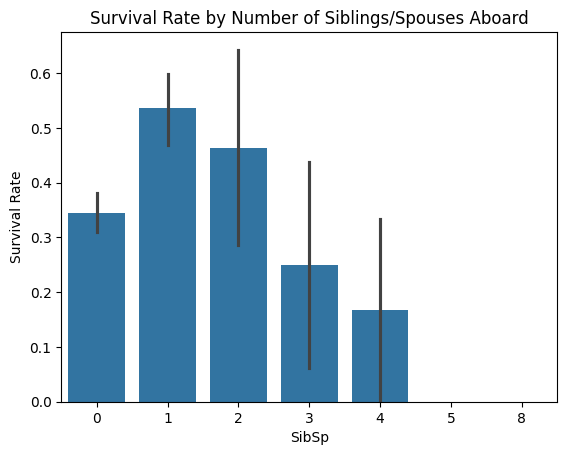

In [ ]:
# Visualize survival rate per siblings/spouses
sns.barplot(x='SibSp', y='Survived', data=train1)
plt.title("Survival Rate by Number of Siblings/Spouses Aboard")
plt.ylabel("Survival Rate")
plt.xlabel("SibSp")
plt.show()

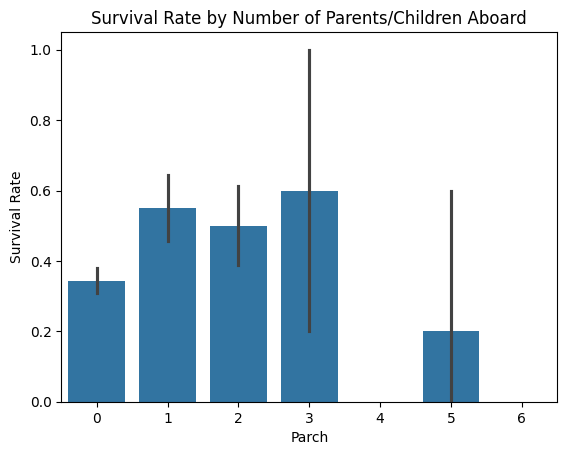

In [ ]:
# Visualize survival rate per parents/children
sns.barplot(x='Parch', y='Survived', data=train1)
plt.title("Survival Rate by Number of Parents/Children Aboard")
plt.ylabel("Survival Rate")
plt.xlabel("Parch")
plt.show()

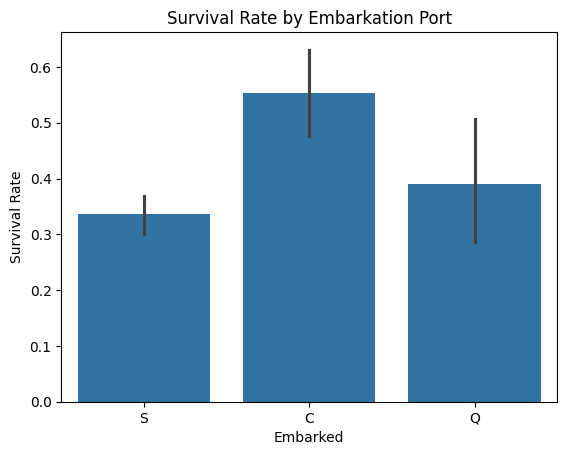

In [ ]:
# Visualize survival rate per Port of departure
sns.barplot(x='Embarked', y='Survived', data=train1)
plt.title("Survival Rate by Embarkation Port")
plt.ylabel("Survival Rate")
plt.xlabel("Embarked")
plt.show()

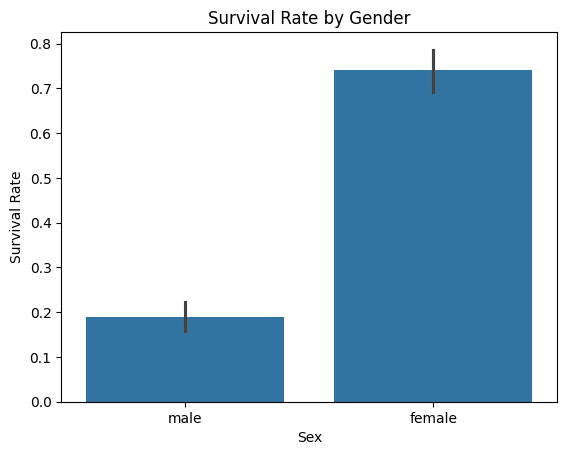

In [ ]:
# Visualize survival rate per gender
sns.barplot(x='Sex', y='Survived', data=train1)
plt.title("Survival Rate by Gender")
plt.ylabel("Survival Rate")
plt.xlabel("Sex")
plt.show()

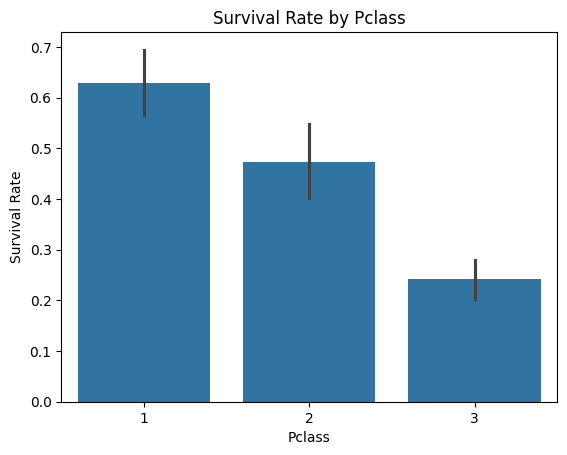

In [230]:
# Visualize survival rate per Pclass
sns.barplot(x='Pclass', y='Survived', data=train1)
plt.title("Survival Rate by Pclass")
plt.ylabel("Survival Rate")
plt.xlabel("Pclass")
plt.show()

In [ ]:
# Fill missing value in Embarked rows with "S" (the most common value)
categorical_feat = ['Embarked']

categorical_trans = Pipeline(steps=[("imputer", SimpleImputer(strategy="constant" , fill_value="S")),
                                    ("encoder", OneHotEncoder(handle_unknown="ignore"))
                                    ])

# Fill missing Age with median
num_feat = ['Age']
num_trans = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))
                            ])

# creates a one-hot encoding pipeline for the 'Sex' feature
sex_feat = ['Sex']
sex_trans = Pipeline(steps=[
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])


In [ ]:
## Setup preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("cat",categorical_trans, categorical_feat),
        ("num", num_trans, num_feat),
        ("sex", sex_trans,sex_feat)
    ]
)


In [ ]:
# Extract title from Name and print the count of each title
train1['Title'] = train1['Name'].str.extract('([A-Za-z]+)\.', expand=False)
print(train1['Title'].value_counts())

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Ms            1
Mme           1
Don           1
Lady          1
Sir           1
Capt          1
Countess      1
Jonkheer      1
Name: count, dtype: int64


<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\Nass\AppData\Local\Temp\ipykernel_18756\3771278543.py:1: SyntaxWarning: invalid escape sequence '\.'
  train1['Title'] = train1['Name'].str.extract('([A-Za-z]+)\.', expand=False)


In [ ]:
rare_titles = ['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 
               'Sir', 'Jonkheer']

# Replace rare titles with the label 'Rare'
train1['Title'] = train1['Title'].replace(rare_titles, 'Rare')

# Replace similar titles with common ones
train1['Title'] = train1['Title'].replace({'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs'})

# Check updated title counts
print(train1['Title'].value_counts())

Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64


In [252]:
bins = [0, 12, 19, 35, 60, 120]
labels = ['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior']

# Create a new AgeGroup column by binning the Age column
train1['AgeGroup'] = pd.cut(train1['Age'], bins=bins, labels=labels)

print(train1['AgeGroup'].value_counts())

AgeGroup
YoungAdult    510
Adult         195
Teen           95
Child          69
Senior         22
Name: count, dtype: int64


In [ ]:
# Create X (all columns except Survived)
X = train1.drop("Survived", axis=1)

# Create y (only the Survived column)
y = train1['Survived']

In [ ]:
# Split X & y into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [288]:
# Create dictionary of model instances
regression_models = {"LogisticRegression": LogisticRegression(max_iter=1000),
                     "RandomForestClassifier": RandomForestClassifier(),
                     "XGBClassifier" : XGBClassifier()}

# Create an empty dictionary for the regression results
regression_results = {}

In [270]:
# Loop through the items in the regression_models dictionary
for model_name, model in regression_models.items():
    
    # Create a model pipeline with a preprocessor step and model step
    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)])
    
    # Fit the model pipeline to the training data
    print(f"Fitting {model_name}...")
    model_pipeline.fit(X_train, y_train)
    
    # Score the model pipeline on the test data appending the model_name to the 
    # results dictionary
    print(f"Scoring {model_name}...")
    regression_results[model_name] = model_pipeline.score(X_test, 
                                                          y_test)

Fitting LogisticRegression...
Scoring LogisticRegression...
Fitting RandomForestClassifier...
Scoring RandomForestClassifier...
Fitting XGBClassifier...
Scoring XGBClassifier...


In [ ]:
# Check the results of each regression model by printing the regression_results dictionary
regression_results

{'LogisticRegression': 0.8100558659217877,
 'RandomForestClassifier': 0.776536312849162,
 'XGBClassifier': 0.7653631284916201}

In [289]:
# Use cross-validation for model robustness
cv_results = {}

for model_name, model in regression_models.items():
    print(f"Running cross-validation for {model_name}...")

    model_pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                                      ("model", model)
                                      ])
    

    scores = cross_val_score(model_pipeline, X, y, scoring="accuracy", cv=5)

    cv_results[model_name] = np.mean(scores)
    print(f"{model_name} CV Accuracy: {np.mean(scores):.4f}")

Running cross-validation for LogisticRegression...
LogisticRegression CV Accuracy: 0.7867
Running cross-validation for RandomForestClassifier...
RandomForestClassifier CV Accuracy: 0.7419
Running cross-validation for XGBClassifier...
XGBClassifier CV Accuracy: 0.7576


In [300]:
# Print result for each model 
cv_results[model_name] = np.mean(scores)
cv_results

{'LogisticRegression': np.float64(0.7867365513778168),
 'RandomForestClassifier': np.float64(0.7418617789215993),
 'XGBClassifier': np.float64(0.757567007720796)}

In [299]:
# Create LogisticRegression Pipeline
final_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LogisticRegression(max_iter=1000))
])

# Fit the LogisticRegression Pipeline to the training data
final_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [301]:
# Make predictions on the test data using the LogisticRegression Pipeline
y_preds = final_model.predict(X_test)

In [302]:
# Accuracy
print("Accuracy:", accuracy_score(y_test, y_preds))

# Precision
print("Precision:", precision_score(y_test, y_preds))

# Recall
print("Recall:", recall_score(y_test, y_preds))

# Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print("Confusion Matrix:\n", cm)

Accuracy: 0.8100558659217877
Precision: 0.75
Recall: 0.65
Confusion Matrix:
 [[106  13]
 [ 21  39]]


In [303]:
# Create a classification report
print("Classification Report:\n", classification_report(y_test, y_preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       119
           1       0.75      0.65      0.70        60

    accuracy                           0.81       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.81      0.81      0.81       179



In [304]:
# # Different LogisticRegression hyperparameters
log_reg_grid = {
    "model__C": np.logspace(-4, 4, 20),
    "model__solver": ["liblinear"]
}

In [305]:
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=log_reg_grid,
    cv=5,
    scoring="accuracy",
    verbose=1,
    n_jobs=1
)

In [306]:
# Fit the grid search on the training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


,estimator,Pipeline(step..._iter=1000))])
,param_grid,"{'model__C': array([1.0000...00000000e+04]), 'model__solver': ['liblinear']}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('cat', ...), ('num', ...), ...]"


In [307]:
# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)

Best Parameters: {'model__C': np.float64(0.08858667904100823), 'model__solver': 'liblinear'}
Best CV Score: 0.7808824977839062


In [309]:
# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_preds = best_model.predict(X_test)

print("Test Accuracy:", best_model.score(X_test, y_test))
print(classification_report(y_test, y_preds))

Test Accuracy: 0.8100558659217877
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       119
           1       0.75      0.65      0.70        60

    accuracy                           0.81       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.81      0.81      0.81       179

